### Random Forest LightGBM Modelling

In [128]:
import pandas as pd
import numpy as np

In [129]:
print('Load data...')
data = pd.read_csv("/Users/jiayangdu/Desktop/PWC/data_for_modeling_full.csv")

Load data...


In [130]:
data.drop(['Unnamed: 0','Unnamed: 0.1','S_INFO_COMPNAME'], axis=1,inplace=True)

In [131]:
data.set_index('Company_code', inplace = True)

In [132]:
data['AQI'] = pd.qcut(data['AQI'], 10, labels=False)
data['DSRI'] = pd.qcut(data['DSRI'], 10,labels=False)
data['GMI'] = pd.qcut(data['GMI'], 10,labels=False)
data['LVGI'] = pd.qcut(data['LVGI'], 10,labels=False)
data['SGAI'] = pd.qcut(data['SGAI'], 10,labels=False)
data['SGI'] = pd.qcut(data['SGI'], 10,labels=False)
data['TATA'] = pd.qcut(data['TATA'], 10,labels=False)

In [133]:
def nandivide(a,b):
    b = b.apply(lambda x:np.nan if x==0 else x)
    r = a/b 
    return r.fillna(0)

In [134]:
data['XueIdx_1'] = nandivide((data['OPER_PROFIT']+data['LESS_FIN_EXP']+data['DEPR_FA_COGA_DPBA']+data['AMORT_INTANG_ASSETS']),data['TOT_LIAB'])
data['XueIdx_3'] = nandivide((data['TOT_PROFIT']- data['OPER_PROFIT']),data['TOT_PROFIT'].apply(lambda x: np.nan if x<=0 else x))
data['XueIdx_4'] = nandivide((data['ACCT_RCV']+data['NOTES_RCV']+data['OTH_RCV']),data['TOT_CUR_ASSETS'])  
data['LOSS'] = (data['TOT_PROFIT']-data['PLUS_NON_OPER_REV']+data['LESS_NON_OPER_EXP']).apply(lambda x: 1 if x<0 else 0)
data['OTHREC'] = nandivide(data['OTH_RCV'],data['TOT_ASSETS'])
data['size'] = data['TOT_ASSETS'].apply(float)
data['equity'] = data['TOT_ASSETS']-data['TOT_LIAB']
data['cfi'] = nandivide(data['NET_CASH_FLOWS_INV_ACT'],data['NET_CASH_FLOWS_OPER_ACT'].apply(abs))
data['cff'] = nandivide(data['NET_CASH_FLOWS_FNC_ACT'],data['NET_CASH_FLOWS_OPER_ACT'].apply(abs))
data['lin1'] =nandivide(data['OTHER_CASH_RECP_RAL_FNC_ACT'],data['TOT_ASSETS'])
data['Cash Flows from Operations'] = data['NET_CASH_FLOWS_OPER_ACT']
data['lin2'] =nandivide(data['TOT_CUR_LIAB'],data['Cash Flows from Operations'].apply(abs))
data['Sales'] = data['TOT_OPER_REV']
data['lin_1'] = nandivide(data['Sales']-data['Cash Flows from Operations'],data['Sales'])
data['turnover'] = nandivide(data['Sales'],data['INVENTORIES'])
data['lin_5'] = nandivide(data['INVENTORIES'],data['TOT_ASSETS'])

In [135]:
###bin continuous variables
columns = ['XueIdx_1','XueIdx_3','XueIdx_4','LOSS','OTHREC','size','equity','cfi','cff','lin1','lin2','lin_1','turnover','lin_5']
for col in columns:
    data[col] = pd.qcut(data[col],10,duplicates='drop',labels=False)

In [225]:
##########定义roc图和confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  ###计算roc和auc

def illus_roc_curve(real,pred):
    # Compute ROC curve and ROC area for each class 
    
    fpr,tpr,threshold = roc_curve(real, pred) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
    
def confusion_matrix(pred,real):
    x = pd.DataFrame()
    x['label'] = real
    x['predict'] = pred

    TruePositive = sum(x[x['predict']==1]['label'])
    FalsePositive = sum(1-x[x['predict']==1]['label'])
    TrueNegative = sum(1-x[x['predict']==0]['label'])
    FalseNegative = sum(x[x['predict']==0]['label'])

    Precision = TruePositive/(TruePositive+FalsePositive)
    Recall = TruePositive/(TruePositive+FalseNegative)
    print('\nPrecision: {}'.format(Precision))
    print('Recall: {}\n'.format(Recall))
    _confusion_matrix = pd.DataFrame({
                    'Negative':{'False':FalseNegative,'True':TrueNegative},
                    'Positive':{'False':FalsePositive,'True':TruePositive}                            
                    })      
    
    print(_confusion_matrix)
    return _confusion_matrix

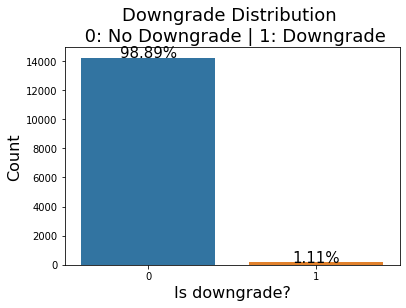

In [226]:
##visulization for label distribution
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plot_tr = sns.countplot(x='label', data=data)
plot_tr.set_title("Downgrade Distribution \n 0: No Downgrade | 1: Downgrade", fontsize=18)
plot_tr.set_xlabel("Is downgrade?", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
total = len(data)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

### Model 2: Decision Tree

reference：

https://www.cnblogs.com/tangxiaobo199181/p/12227543.html

https://zhuanlan.zhihu.com/p/108628169

https://blog.csdn.net/xbinworld/article/details/44660339

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

https://blog.csdn.net/qq_38923076/article/details/82931340

In [198]:
#train test split
from sklearn.model_selection import train_test_split
reg_cols = ['AQI',
            'DSRI',
            'GMI',
            'LVGI',
            'SGAI',
            'SGI',
            'TATA',
            'XueIdx_1',
            'XueIdx_3',
            'XueIdx_4',
            'LOSS',
            'OTHREC',
            'size',
            'equity',
            'cfi',
            'cff',
            'lin1',
            'lin2',
            'lin_1',
            'turnover',
            'lin_5']

y = data['label']
X = data[reg_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)

In [199]:
# define decision tree (basic)
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

#fit
r = dt.fit(X_train,y_train)

#predict
y_pred_train= dt.predict(X_train)
y_pred_test = dt.predict(X_test)

We will use AUC (Area Under Curve) as the evaluation metric. Our target value is binary so it’s a binary classification problem. AUC is a good way for evaluation for this type of problems.

In [200]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5304716052853529

In [205]:
# confusion_matrix(y_pred_train, y_train)
confusion_matrix(y_pred_test, y_test)


Precision: 0.05660377358490566
Recall: 0.075

       Negative  Positive
False        37        50
True       3507         3


,Negative,Positive
False,37,50
True,3507,3


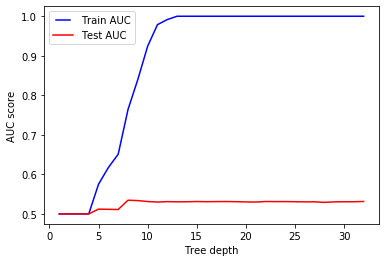

In [207]:
#parameter tuning
#max_depth: This indicates how deep the tree can be. 
#The deeper the tree, the more splits it has and it captures more information about the data. 
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(x_train, y_train)
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

We see that our model overfits for large depth values. The tree perfectly predicts all of the train data, however, it fails to generalize the findings for new data

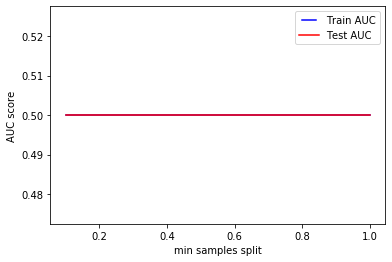

In [210]:
#min_samples_split represents the minimum number of samples required to split an internal node. 
#When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node. 
#Here we will vary the parameter from 10% to 100% of the samples
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(x_train, y_train)
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

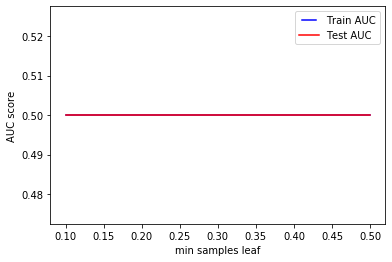

In [214]:
#min_samples_leaf is The minimum number of samples required to be at a leaf node.
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(x_train, y_train)
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

### Model 3: Random Forest

reference:

https://www.jiqizhixin.com/articles/2017-07-31-3

https://easyai.tech/ai-definition/random-forest/

https://towardsdatascience.com/understanding-random-forest-58381e0602d2

https://blog.csdn.net/qq547276542/article/details/78304454

https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d

In [218]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
r = rf.fit(X_train,y_train)
y_pred_train= model.predict(X_train)
y_pred_test = model.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3557
           1       1.00      0.90      0.95        40

    accuracy                           1.00      3597
   macro avg       1.00      0.95      0.97      3597
weighted avg       1.00      1.00      1.00      3597

预估结果的ROC图:


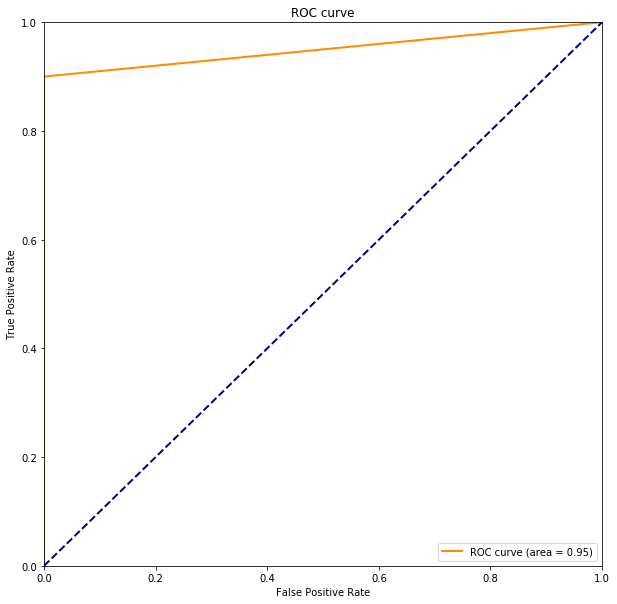

In [219]:
# confusion_matrix(y_pred_train, y_train)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred_test))
print('预估结果的ROC图:')
illus_roc_curve(y_test,y_pred_test)

In [224]:
confusion_matrix(y_pred_test, y_test)


Precision: 1.0
Recall: 0.9

       Negative  Positive
False         4         0
True       3557        36


,Negative,Positive
False,4,0
True,3557,36


### Model 4:  LightGBM

reference: 

https://towardsdatascience.com/xgboost-python-example-42777d01001e

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

https://www.kaggle.com/roydatascience/light-gbm-with-complete-eda

https://www.cnblogs.com/chenxiangzhen/p/10962983.html

https://blog.csdn.net/weixin_41411460/article/details/104290547

https://zhuanlan.zhihu.com/p/27916208

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

https://towardsdatascience.com/lightgbm-vs-xgboost-which-algorithm-win-the-race-1ff7dd4917d

In [143]:
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [144]:
# 设定训练集和测试集
reg_cols = ['AQI',
            'DSRI',
            'GMI',
            'LVGI',
            'SGAI',
            'SGI',
            'TATA',
            'XueIdx_1',
            'XueIdx_3',
            'XueIdx_4',
            'LOSS',
            'OTHREC',
            'size',
            'equity',
            'cfi',
            'cff',
            'lin1',
            'lin2',
            'lin_1',
            'turnover',
            'lin_5']

#y = data['label'].values
#X = data[reg_cols].values
#n = int(len(X)*0.7)
#X_train = X[:n]
#y_train = y[:n]
#X_test = X[n:]
#y_test = y[n:]
y = data['label']
X = data[reg_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=42)

In [145]:
# 构建lgb中的Dataset格式，和xgboost中的DMatrix是对应的
lgb_train = lgb.Dataset(X_train, y_train, feature_name =reg_cols)
lgb_dev = lgb.Dataset(X_test,y_test, reference = lgb_train)

In [164]:
#####################
###网格搜索查找最优超参数
# 配合scikit-learn的网格搜索交叉验证选择最优超参数
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMRegressor(num_leaves=30)

param_grid = {
    'learning_rate': [0.01, 0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09, 0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1],
    'n_estimators': [20, 40, 50],
    'feature_fraction':[0.5,0.6,0.7,0.8,0.9],
    'bagging_fraction':[0.5,0.6,0.7,0.8,0.9]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, y_train)

print('用网格搜索找到的最优超参数为:')
print(gbm.best_params_)

用网格搜索找到的最优超参数为:
{'bagging_fraction': 0.5, 'feature_fraction': 0.6, 'learning_rate': 0.06, 'n_estimators': 50}


开始训练...
[1]	valid_0's fair: 0.00303193	valid_0's l2: 0.00972768
Training until validation scores don't improve for 10 rounds
[2]	valid_0's fair: 0.00302611	valid_0's l2: 0.00969545
[3]	valid_0's fair: 0.00301401	valid_0's l2: 0.0096319
[4]	valid_0's fair: 0.00299897	valid_0's l2: 0.00956075
[5]	valid_0's fair: 0.00299059	valid_0's l2: 0.00951995
[6]	valid_0's fair: 0.00298205	valid_0's l2: 0.00947615
[7]	valid_0's fair: 0.00297069	valid_0's l2: 0.00942347
[8]	valid_0's fair: 0.00296149	valid_0's l2: 0.00937783
[9]	valid_0's fair: 0.00295247	valid_0's l2: 0.0093298
[10]	valid_0's fair: 0.00293909	valid_0's l2: 0.00926725
[11]	valid_0's fair: 0.00293933	valid_0's l2: 0.00925782
[12]	valid_0's fair: 0.00294141	valid_0's l2: 0.00924627
[13]	valid_0's fair: 0.00294305	valid_0's l2: 0.00924495
[14]	valid_0's fair: 0.00294619	valid_0's l2: 0.00924159
[15]	valid_0's fair: 0.00293873	valid_0's l2: 0.00918764
[16]	valid_0's fair: 0.0029362	valid_0's l2: 0.00915552
[17]	valid_0's fair: 0.00293608

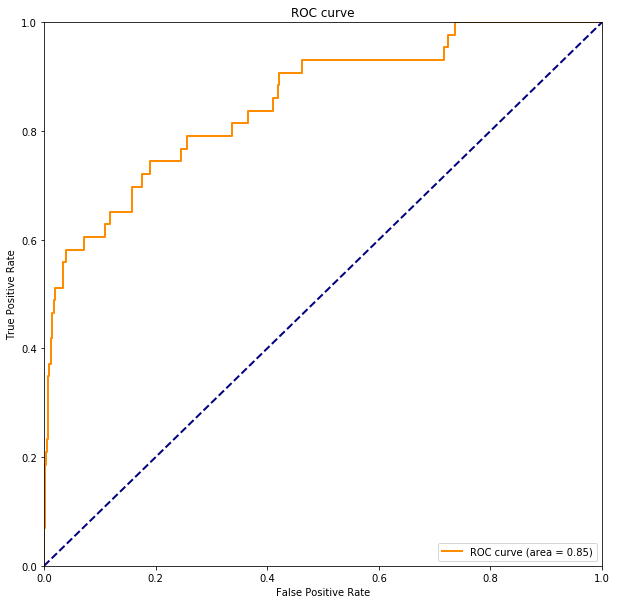

In [165]:
# 参数
params = {
    'task':'train',
    'boosting_type':'gbdt',
    'metric': {'l2','fair'},
    'num_leaves':30,
    'num_threads':8,
    'learning_rate':0.06,
    'feature_fraction':0.6,
    'bagging_fraction':0.5,
    'bagging_freq':5,
    'verbose':0
}

print('开始训练...')
# 训练
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_dev,
               early_stopping_rounds=10)
# 保存模型
print('保存模型...')
# 保存模型到文件中
gbm.save_model('model.txt')
print('开始预测...')
# 预测
y_pred1 = gbm.predict(X_test, num_iteration = gbm.best_iteration)
# 评估
print('预估结果的rmse为:')
print(mean_squared_error(y_test, y_pred1) ** 0.5) #Root Mean Square Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data. 
#ROC curve
print('预估结果的ROC图:')
illus_roc_curve(y_test,y_pred1)

In [166]:
# 特征重要度
fi = pd.Series(gbm.feature_importance(), index = gbm.feature_name())
fi = fi.sort_values(ascending=False)
fi

equity      72
OTHREC      55
XueIdx_1    52
XueIdx_3    51
SGAI        48
lin2        47
lin_1       46
size        46
TATA        46
lin1        44
AQI         43
LVGI        42
cff         40
cfi         34
turnover    32
GMI         32
lin_5       29
SGI         28
XueIdx_4    27
DSRI        27
LOSS         0
dtype: int32

In [167]:
def confusion_matrix(pred,real):
    x = pd.DataFrame()
    x['label'] = real
    x['predict'] = pred

    TruePositive = sum(x[x['predict']==1]['label'])
    FalsePositive = sum(1-x[x['predict']==1]['label'])
    TrueNegative = sum(1-x[x['predict']==0]['label'])
    FalseNegative = sum(x[x['predict']==0]['label'])

    Precision = TruePositive/(TruePositive+FalsePositive)
    Recall = TruePositive/(TruePositive+FalseNegative)
    print('\nPrecision: {}'.format(Precision))
    print('Recall: {}\n'.format(Recall))
    _confusion_matrix = pd.DataFrame({
                    'Negative':{'False':FalseNegative,'True':TrueNegative},
                    'Positive':{'False':FalsePositive,'True':TruePositive}                            
                    })      
    
    print(_confusion_matrix)
    return _confusion_matrix

In [168]:
for alpha in [0.0046,0.0047,0.00475,0.0048,0.005]:
    print( '--------- {} ---------'.format(alpha))
    pred2 = [1 if x>alpha else 0 for x in y_pred1]
    real = y_test
    confusion_matrix(pred2,real)

--------- 0.0046 ---------

Precision: 0.020429544264012573
Recall: 0.9069767441860465

       Negative  Positive
False         4      1870
True       2404        39
--------- 0.0047 ---------

Precision: 0.020537124802527645
Recall: 0.9069767441860465

       Negative  Positive
False         4      1860
True       2414        39
--------- 0.00475 ---------

Precision: 0.02058047493403694
Recall: 0.9069767441860465

       Negative  Positive
False         4      1856
True       2418        39
--------- 0.0048 ---------

Precision: 0.020624008461131677
Recall: 0.9069767441860465

       Negative  Positive
False         4      1852
True       2422        39
--------- 0.005 ---------

Precision: 0.02092274678111588
Recall: 0.9069767441860465

       Negative  Positive
False         4      1825
True       2449        39


开始预测...
预估结果的rmse为:
0.0934085905869073
预估结果的ROC图:


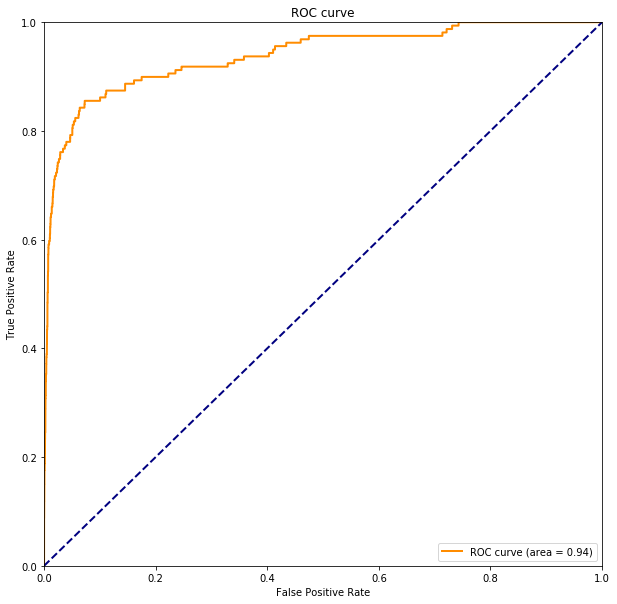

In [169]:
##########使用############
md = lgb.Booster(model_file='model.txt')
# 预测整体 
print('开始预测...')
y_pred2 = md.predict(X, num_iteration = gbm.best_iteration)
# 评估
print('预估结果的rmse为:')
print(mean_squared_error(y, y_pred2) ** 0.5) #Root Mean Square Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data. 
#ROC curve
print('预估结果的ROC图:')
illus_roc_curve(y,y_pred2)